==============================================================================================
# Practicum 5 - Part 2

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Group A- Group F): November 30th, 23:00 h**

**Deadline (Group B): November 1st, 23:00 h**

==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

**Part 1:**

- Gaussian filters
- Descriptors based on texture 

**Part 2:**

- Distance between images and similarity search

### Imports

In [171]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
from scipy.ndimage import convolve
from skimage.exposure import histogram
from skimage import img_as_float


import pickle

import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import joblib  ## 
from random import randrange

In [55]:
def visualize_n(image_list):

    fig=plt.figure(figsize=(15,15))
    for i in range(len(image_list)):
        
        fig.add_subplot(1,len(image_list),i +1)
        plt.imshow(image_list[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])

def normalize(image): return (image[:,:]- image.min())/(image.max() - image.min())

# 1 Import previous functions



## Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">

We import Leung-Malik filters as follows:

In [29]:
import LM_filters

In [30]:
filter_bank = LM_filters.makeLMfilters()
filter_bank_list = [filter_bank[:,:,i] for i in range(0,len(filter_bank)-1)]
filter_bank.shape

(49, 49, 48)

### Plotting all filters

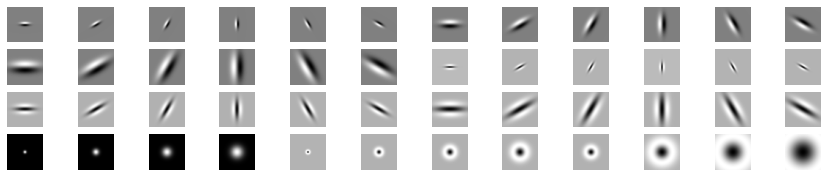

In [31]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1

## Import functions

We need to use `extract_features()` and  `get_dataset_features()` from **Practicum 5 - Part 1**.

On the one hand, function `extract_features(image, filter_bank, n_filters)` returns a feature vector of shape `n_filters`, from the filter bank, using a  single image `image`

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$


In [32]:
def apply_filters(im,  filters):
    return np.array([np.abs(convolve(im, f)) for f in filters])

def extract_features(image, filter_bank_list, n_filters):
    
    filters = filter_bank_list[0:n_filters]
    
    filtered_images = apply_filters(image, filters)  
    
    return np.array([np.mean(np.abs(f_image.flatten())) for f_image in filtered_images])

On the other hand, function `get_dataset_features(all_images, filter_bank)`, that applies `extract_features()`, returns a matrix containing the feature vectors for all the images in a dataset.

In [42]:
from tqdm import tqdm_notebook

def get_dataset_features(all_images, bank, n_filters):
    
    result = [extract_features(image, bank, n_filters) for image in tqdm_notebook(all_images)]
    
    return np.array(result)

**Hint: Please, check all the functions are well working before continuing!!!**

## Load & resize the dataset

**3.1** Similarly to **Practicum 5 - Part 1**, read all the images in the directories, **resized them to 250x250 pixels** and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>


In [43]:
pizza_images = [resize(imread("images/pizza/" + image), (250, 250)) for image in os.listdir("images/pizza/")]
flowers_images = [resize(imread("images/flowers/" + image), (250, 250)) for image in os.listdir("images/flowers/")]
pets_images = [resize(imread("images/pets/" + image), (250, 250)) for image in os.listdir("images/pets/")]

In [79]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
all_images_gr = [rgb2gray(image) for image in all_images]
feature_vectors=get_dataset_features(all_images_gr,  filter_bank_list, n_filters=len(filter_bank_list))
try:
    with open('feature_vector2.pkl', 'rb') as fp:
        feature_vectors = pickle.load(fp)
except:
    print("Calculate feature vector")
    feature_vectors=get_dataset_features(all_images_gr,  filter_bank_list, n_filters=len(filter_bank_list))
    with open('feature_vector2.pkl', 'wb') as fp:
        pickle.dump(feature_vectors, fp, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/87 [00:00<?, ?it/s]

In [64]:
print("Pizza:\t" , len(pizza_images))
print("Flowers:" , len(flowers_images))
print("Pets:\t" , len(pets_images))

Pizza:	 30
Flowers: 28
Pets:	 29



# 2 Retrieving the most similar images


## Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$




**3.2** Implement a function `retrieve_images(im, all_images, filter_bank, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be the images of interest `im`, the whole data set `all_images`, the filter bank and an integer value `k`, which defines the number of images to be shown.

The function should return the ordered vector of distances.

<img src="./images/indice.png" >


In [88]:
def retrieve_images(im, all_images, filter_bank_list, n_features, k=5):   
    im = rgb2gray(resize(im, (250, 250)))
    image_feature = extract_features(im, filter_bank_list, n_features)
    
    dists = [np.linalg.norm((feature[:n_features] - image_feature)) for feature in feature_vectors]
    closest = list(zip(range(len(dists)), dists))
    closest.sort(key=lambda x:x[1])

    return [all_images[i[0]] for i in closest[:k]], [i[1] for i in closest[:k]]

Try your function using ``/images/pizza.jpg``.

In [78]:
# Try your function
pizza = imread('./images/pizza.jpg')
closest, distances = retrieve_images( pizza, all_images, filter_bank_list, k=5)

Plot the ordered distance vector

In [60]:
visualize_n(closest)
distances
raise NotImplementedError

NotImplementedError: 

**3.3** Try your function using a different number of closest images `k`.

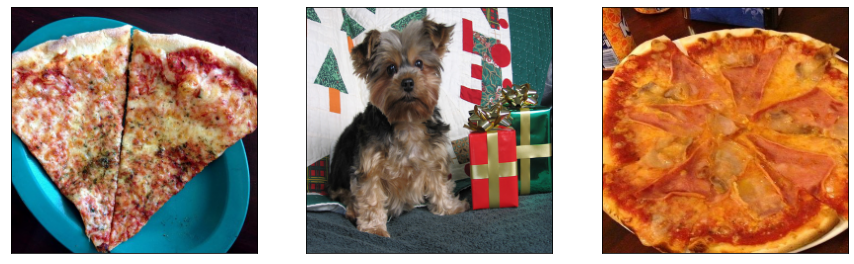

In [62]:
closest_rand, distances_rand = retrieve_images( pizza, all_images, filter_bank_list, k=randrange(1, len(all_images)))
visualize_n(closest_rand)

**3.4** (Optional) Try your function using ``/images/dog.jpg``, and ``/images/flower.jpg``

In [ ]:
# Your solution here

## Compute the accuracy of the algorithm: given a query image. 

**3.5** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [67]:
class_labels = np.concatenate(
    (np.zeros(len(pizza_images)), 
     np.ones(len(flowers_images)),  
     2*np.ones(len(pets_images)))
).reshape(len(all_images),1)

In [200]:
def accuracy(feature_vectors, class_labels, im_features, class_im, n_features, k=5):
    #im_features -> feat query
    #class_im -> class query
    im_features = im_features[:n_features]

    
    dists = [np.linalg.norm((feature[:n_features] - im_features)) for feature in feature_vectors]
    closest = list(zip(range(len(dists)), dists))
    closest.sort(key=lambda x:x[1])

    
#     visualize_n([all_images[i[0]] for i in closest[:k]])
    
    closest_labels = [class_labels[i[0]] for i in closest[:k] if i[1] != 0.0]
    
    
#     print(closest_labels)
    
    trues = [class_im==i for i in closest_labels]

    return np.count_nonzero(np.array(trues))/len(closest_labels)


[array([2.]), array([0.]), array([0.]), array([2.])]
acc:  0.5


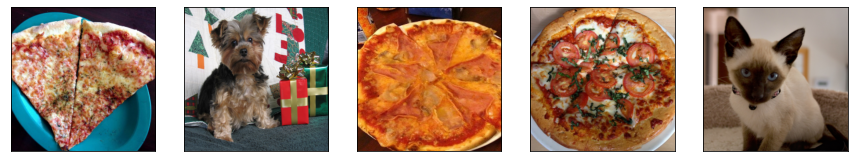

In [117]:
# Try your function
im = rgb2gray(resize(pizza, (250, 250)))
im_features = extract_features(im, filter_bank_list, len(filter_bank_list))
print("acc: ", accuracy(feature_vectors, class_labels, im_features, 0, len(filter_bank_list), 5))

Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

acc:  0.5555555555555556


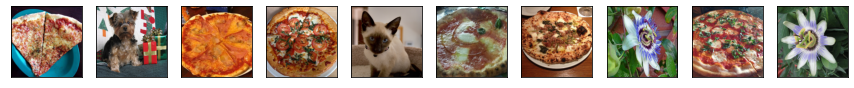

In [126]:
closest_10, distances_rand = retrieve_images(im, all_images, filter_bank_list, len(filter_bank_list), k=10)
visualize_n(closest_10)

print("acc: ", accuracy(feature_vectors, class_labels, im_features, 0,len(filter_bank_list), 10))

**3.6** Modify (if necessary) functions `extract_features()` and `get_dataset_features()` in order to use only a given number of filters. Compute the accuracy using `n_filters=6`, `n_filters=18` and `n_filters=36`. 

Comment the results.

acc:  0.4444444444444444


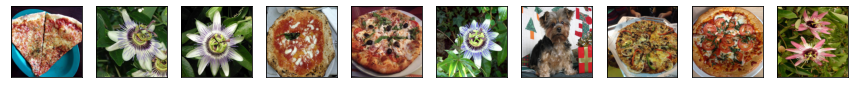

In [123]:
closest_10, distances_rand = retrieve_images(im, all_images, filter_bank_list, 6, k=10)
visualize_n(closest_10)

print("acc: ", accuracy(feature_vectors, class_labels, im_features, 0, 6, 10))

acc:  0.4444444444444444


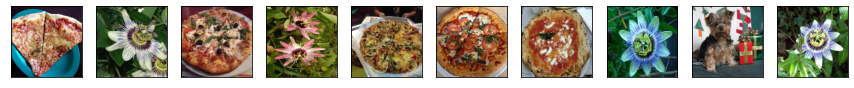

In [124]:
closest_10, distances_rand = retrieve_images(im, all_images, filter_bank_list, 18, k=10)
visualize_n(closest_10)

print("acc: ", accuracy(feature_vectors, class_labels, im_features, 0, 18, 10))

acc:  0.4444444444444444


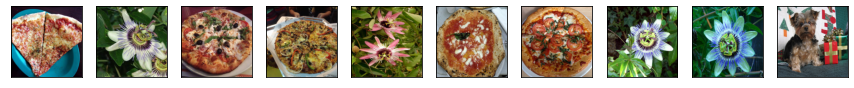

In [125]:
closest_10, distances_rand = retrieve_images(im, all_images, filter_bank_list, 36, k=10)
visualize_n(closest_10)

print("acc: ", accuracy(feature_vectors, class_labels, im_features, 0, 36, 10))

**3.7** (Optional) Try your function using other images and modifying the number of filters to be used.

**Hint:** You can use `im_features = feature_vectors[j]` and `class_im = class_labels[j]`, for a given `j` value, in order to simplify the problem, instead of recomputing the features for a new image. **Remember** to exclude the query image from the retrieved images!.

acc:  0.6666666666666666


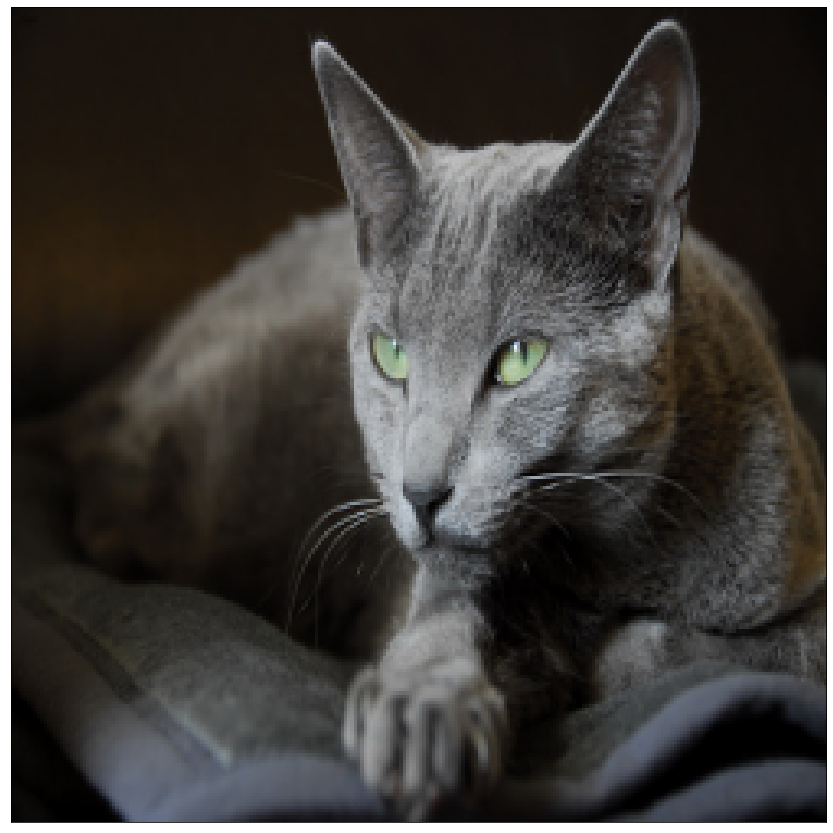

In [168]:
#la pizza es la 12
image_num = 80
visualize_n([all_images[image_num]])
im_features = feature_vectors[image_num]
class_im = class_labels[image_num]

print("acc: ", accuracy(feature_vectors, class_labels, im_features, class_im, len(filter_bank_list),10))

# 3 Image retrieval based on texture and color. 

**3.8** Make a function ` lm_features_rgb`  that returns the features based on a color descriptor. 

**Hint:** How will you define it? What should be the dimensonality of the new descriptor?.


In [204]:
def lm_features_rgbt(image, numberOfBins=16):
        
    ## Complete this function
    
    im_gr = rgb2gray(resize(im, (250, 250)))
    
    texture_features = extract_features(im_gr, filter_bank_list, len(filter_bank_list))

    hst_r, bins_r = histogram( img_as_float(image[:,:,0]), nbins=numberOfBins)
    hst_g, bins_g = histogram( img_as_float(image[:,:,1]), nbins=numberOfBins)
    hst_b, bins_b = histogram( img_as_float(image[:,:,2]), nbins=numberOfBins)
    
    return np.concatenate((
        texture_features,
        hst_r,
        hst_g,
        hst_b
    ))

In [205]:
def lm_features_rgb(image, numberOfBins=16):

    hst_r, bins_r = histogram( img_as_float(image[:,:,0]), nbins=numberOfBins)
    hst_g, bins_g = histogram( img_as_float(image[:,:,1]), nbins=numberOfBins)
    hst_b, bins_b = histogram( img_as_float(image[:,:,2]), nbins=numberOfBins)
    
    return np.concatenate((
        hst_r,
        hst_g,
        hst_b
    ))

In [196]:
# Try your function
lm_rgb_features = lm_features_rgb(resize(imread("images/pizza/3678290.jpg"), (250,250)))
print(lm_rgb_features.shape)

(48,)



## Apply the function to all the images in the dataset

**3.9** Using ` lm_features_rgb` build the features of all the datapoints in and save them in `X_lm_rgb`.

**Hint:** You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [191]:
# Your solution here

In [192]:
import joblib
X_lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in tqdm_notebook(all_images))

  0%|          | 0/87 [00:00<?, ?it/s]

## Compute the accuracy of the method using lm rgb features

**3.10** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [197]:
def retrieve_images_rgb(image_feature, feature_vector, all_images, k=5):   
    
    dists = [np.linalg.norm((feature - image_feature)) for feature in feature_vector]
    closest = list(zip(range(len(dists)), dists))
    closest.sort(key=lambda x:x[1])

    return [all_images[i[0]] for i in closest[:k]], [i[1] for i in closest[:k]]

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
acc:  1.0


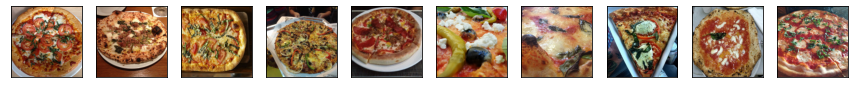

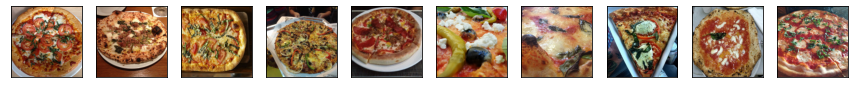

In [203]:
# Your solution here
visualize_n(retrieve_images_rgb(lm_rgb_features, X_lm_rgb, all_images, k=10)[0])
print("acc: ", accuracy(X_lm_rgb, class_labels, lm_rgb_features, 0, 16*3, 10))

## Compare the accuracy of the method using a) texture, b) color and c) texture + color  features

**3.10** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here


**3.11** Compute the accuracy of the retrieved images using the features that contain texture and color information. Make a plot of the 4 closest images to the query images in the `lm_rgb_texture` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here